In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mpt
from matplotlib.pyplot import subplots, imshow, figure, plot, bar
import os
from os.path import join
import re
import json
import pickle
import sys
sys.path.append('../misc/tracecmd')
import tracecmd

In [6]:
expname = '04-11_05-01' # initial experiment design
expname = '04-12_04-29' # tuned parameters a bit
expname = '04-12_14-52' # add second load

# live experiments
expname = '' # pacman on alba-tpi

expbase = join('../exp', expname)
with open(join(expbase, 'experiment.json')) as f:
    expdata = json.load(f)
if os.path.exists(f := join(expbase, 'main.json')):
    with open(f) as f:
        expdata['main'] = json.load(f)
expfiles = os.listdir(expbase)
loads = {}
for x in expfiles:
    if m := re.fullmatch(r'load\.(.+)\.pkl', x):
        with open(join(expbase, x), 'rb') as f:
            load = pickle.load(f)
            load['times'] = np.array(load['times'])
            loads[m.group(1)] = load
trace = tracecmd.Trace(join(expbase, 'trace.dat'))
events = []
while (event := trace.read_next_event()) != None:
    events.append(event)
events = sorted(events, key=lambda e: e.ts)
gds_events = [ e for e in events if e.name == 'global_dirty_state' ]
bdp_events = [ e for e in events if e.name == 'balance_dirty_pages' ]

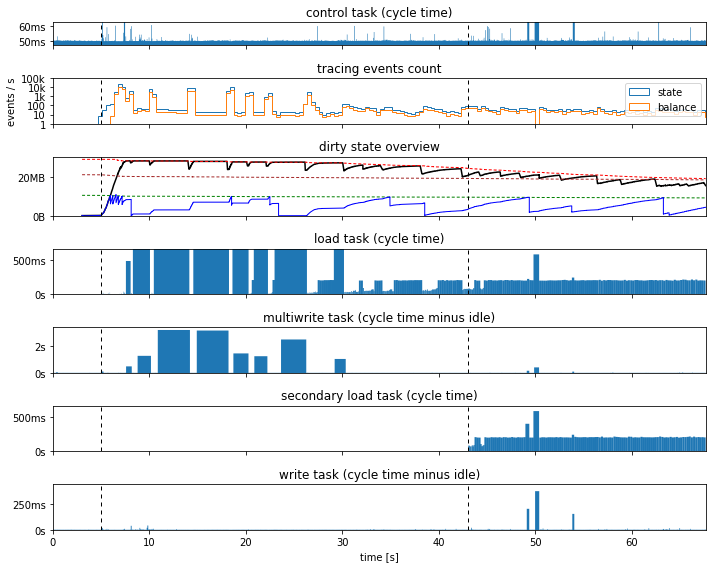

In [16]:
fig, axs = subplots(sharex=True, figsize=(10,8), nrows=7, gridspec_kw=dict( \
        height_ratios=[0.5,1,1.3,1,1,1,1] ))
start, end = loads['l1']['times'][[0,-1]]
axs[0].set_xlim(0, end - start)
def render_segments(ax, edges, values, *args, **kwargs):
    if len(edges) != len(values)+1:
        raise Exception('Got {} edges, {} values'.format(len(edges), len(values)))
    res = ax.fill_between(np.repeat(edges, 2)[1:-1], np.repeat(values, 2), -1, *args, **kwargs)
    ax.set_ylim(0, ax.get_ylim()[1])
    return res

for ax in axs:
    #ax.grid(axis='x')
    #ax.set_ylabel('duration [s]')
    ax.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='s'))

ax = axs[0]; load = loads['c1']; ps = load['params']; ts = load['times'] - start
ax.set_title('control task (cycle time)')
render_segments(ax, ts, np.diff(ts))
ax.set_ylim(ps['idle']*(1-.05), ps['idle']*1.25)

if False:
    ax = axs[3]; load = loads['l1']; ps = load['params']; ts = load['times'] - start
    ax.set_title('load task (cycle time)')
    ts = ts[1:]
    render_segments(ax, ts, np.diff(ts))

    ax = axs[5]; load = loads['l2']; ps = load['params']; ts = load['times'] - start
    ax.set_title('secondary load task (cycle time)')
    ts = ts[1:]
    render_segments(ax, ts, np.diff(ts))
    #ax.set_ylim(axs[3].get_ylim())
    axs[3].set_ylim(ax.get_ylim())

ax = axs[6]; load = loads['w1']; ps = load['params']; ts = load['times'] - start
ax.set_title('write task (cycle time minus idle)')
render_segments(ax, ts, np.diff(ts) - ps['idle'])

ax = axs[4]; load = loads['mw1']; ps = load['params']; ts = load['times'] - start
ax.set_title('multiwrite task (cycle time minus idle)')
render_segments(ax, ts, np.diff(ts) - ps['idle'])

ax = axs[1]
ax.set_title('tracing events count')
ax.set_ylabel('events / s')
def plot_times(events, *args, **kwargs):
    ts = np.array([ e.ts / 1e9 for e in events ]) - start
    bins = int((end - start) / .4)
    weights = [bins / (end - start)]*len(ts)
    ax.hist(ts, range=(start, end), weights=weights, bins=bins, log=True, histtype='step', *args, **kwargs)
plot_times(gds_events, label='state')
plot_times(bdp_events, label='balance')
ax.set_ylim(1,100e3)
ax.yaxis.set_ticks((1,1e1,1e2,1e3,1e4,1e5))
ax.yaxis.set_major_formatter(mpt.EngFormatter(sep=''))
ax.legend()

ax = axs[2]
ax.set_title('dirty state overview')
from_pages = lambda pages: pages * 4096
ts = np.array([ e.ts / 1e9 for e in gds_events ]) - start

ax.plot(ts, [ from_pages(int(e['background_thresh'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='green')
ax.plot(ts, [ from_pages(int(e['dirty_thresh'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='brown')
ax.plot(ts, [ from_pages(int(e['dirty_limit'])) for e in gds_events ], lw=1, ls=(0,(3,2)), color='red')
ax.plot(ts, [ from_pages(int(e['nr_dirty'])+int(e['nr_writeback'])) for e in gds_events ], color='black', zorder=-1)
ax.plot(ts, [ from_pages(int(e['nr_dirty'])) for e in gds_events ], color='blue', lw=1)
ax.yaxis.set_major_formatter(mpt.EngFormatter(sep='', unit='B'))
ax.set_ylim(0, ax.get_ylim()[1])
#ax.legend()

for ax in axs:
    for load in loads.values():
        if load['kind'] == 'load':
            ax.plot([ load['times'][1] - start ]*2, ax.get_ylim(), lw=1, ls=(0, (4,4)), color='black')
    if 'main' in expdata:
        ax.plot([ expdata['main']['start'] - start ]*2, ax.get_ylim(), lw=1, ls=(0, (4,4)), color='black')
axs[-1].set_xlabel('time [s]')
axs[-1].xaxis.set_major_locator(mpt.MultipleLocator(10))
fig.tight_layout()
#fig.savefig('out.png', dpi=150)